In [1]:
import itertools
from basics import *
from plotting import *
from plotting import savefig
from ase.io import read
import seaborn as sns
from scipy import stats

plt.style.use("paper")

In [2]:
root_dir = "../data/02-mace"
experiments = ["facet", "covsplit", "evencov"]
facets = [100, 111, 211, 331, 410, 711]

In [3]:
df = []
for exp in experiments:
    for facet in tqdm.tqdm(facets):
        base_path = os.path.join(root_dir, f"{exp}-{facet}")
        dsets = sorted(os.listdir(base_path))
        
        for eval_name in dsets:
            dset = read(f"{base_path}/{eval_name}", index=":")

            for i, at in enumerate(dset):
                df.append({
                    "exp": exp,
                    "train_facet": facet,
                    "test_facet": eval_name.replace("-test.xyz", ""),
                    "index": i,
                    "crystal_id": at.info["crystal_id"],
                    "nads": at.arrays["adsorbate"].max(),
                    "n_atoms": len(at),
                    "true": at.info["energy"],
                    "pred": at.info["MACE_energy"],
                })

df = pd.DataFrame(df)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  4.39it/s]


In [4]:
df["npred"] = df["pred"] / df["nads"]
df["ntrue"] = df["true"] / df["nads"]

In [5]:
metrics = []
for (exp, train, test), grp in df.groupby(["exp", "train_facet", "test_facet"]):    
    _x = grp["ntrue"]
    _y = grp["npred"]
    err = _y - _x
    
    rmse = np.sqrt((err ** 2).mean())
    mae = np.abs(err).mean()
    spearman, _ = stats.spearmanr(_x, _y)
    pearson, _ = stats.pearsonr(_x, _y)
    
    metrics.append({
        "exp": exp,
        "train_facet": train,
        "test_facet": test,
        "rmse": rmse,
        "mae": mae,
        "spearman": spearman,
        "pearson": pearson,
    })

metrics = pd.DataFrame(metrics)
metrics.to_csv("../data/03-mace-extrapolation/mace.csv")

In [6]:
mace711 = metrics.loc[
    (metrics.train_facet == 711)
    & (metrics.exp == "facet")
].drop(["train_facet", "exp"], axis=1).rename(columns={"test_facet": "facet"}).reset_index(drop=True)

mace711.to_csv("../data/02-extrapolation/mace.csv")

# Plotting all results

## Facet to facet results

In [7]:
table = metrics.loc[metrics["exp"] == "facet"].pivot(index="train_facet", columns="test_facet", values="rmse")
table = table * 1000

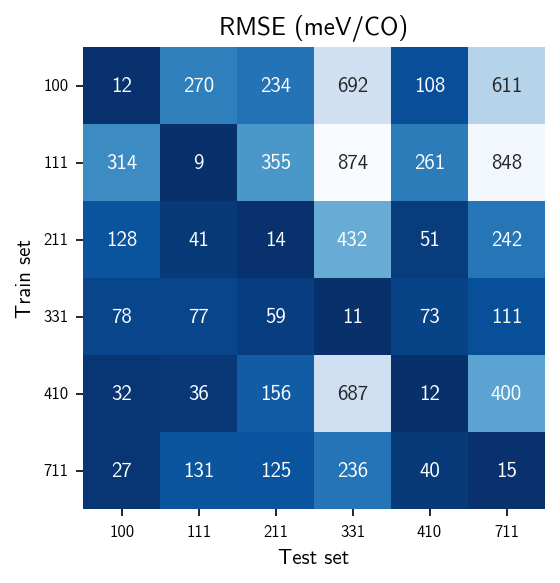

In [8]:
fig, ax = plt.subplots(figsize=(4, 4))

sns.heatmap(
    table,
    annot=True,
    fmt=".0f",
    cbar=False,
    square=True,
    ax=ax,
    cmap="Blues_r"
)

ax.set_xlabel("Test set")
ax.set_ylabel("Train set")
ax.set_yticklabels(ax.get_xticklabels(), rotation=0)

ax.set_title("RMSE (meV/CO)")
savefig(fig, "02-extrapolation-facets-rmse.pdf")
plt.show()

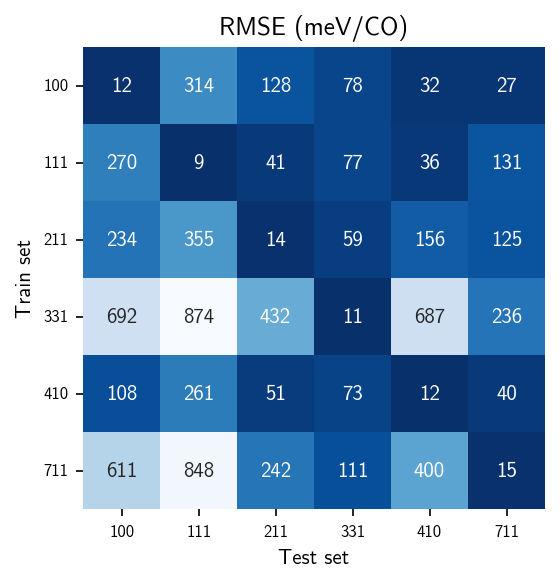

In [9]:
fig, ax = plt.subplots(figsize=(4, 4))

sns.heatmap(
    table.T,
    annot=True,
    fmt=".0f",
    cbar=False,
    square=True,
    ax=ax,
    cmap="Blues_r"
)

ax.set_xlabel("Test set")
ax.set_ylabel("Train set")
ax.set_yticklabels(ax.get_xticklabels(), rotation=0)

ax.set_title("RMSE (meV/CO)")
savefig(fig, "02-extrapolation-facets-transposed.pdf")
plt.show()

/var/folders/2q/s8z166bx6s99wf5prpd1d3q0001w6_/T/ipykernel_19066/1391773873.py:32: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


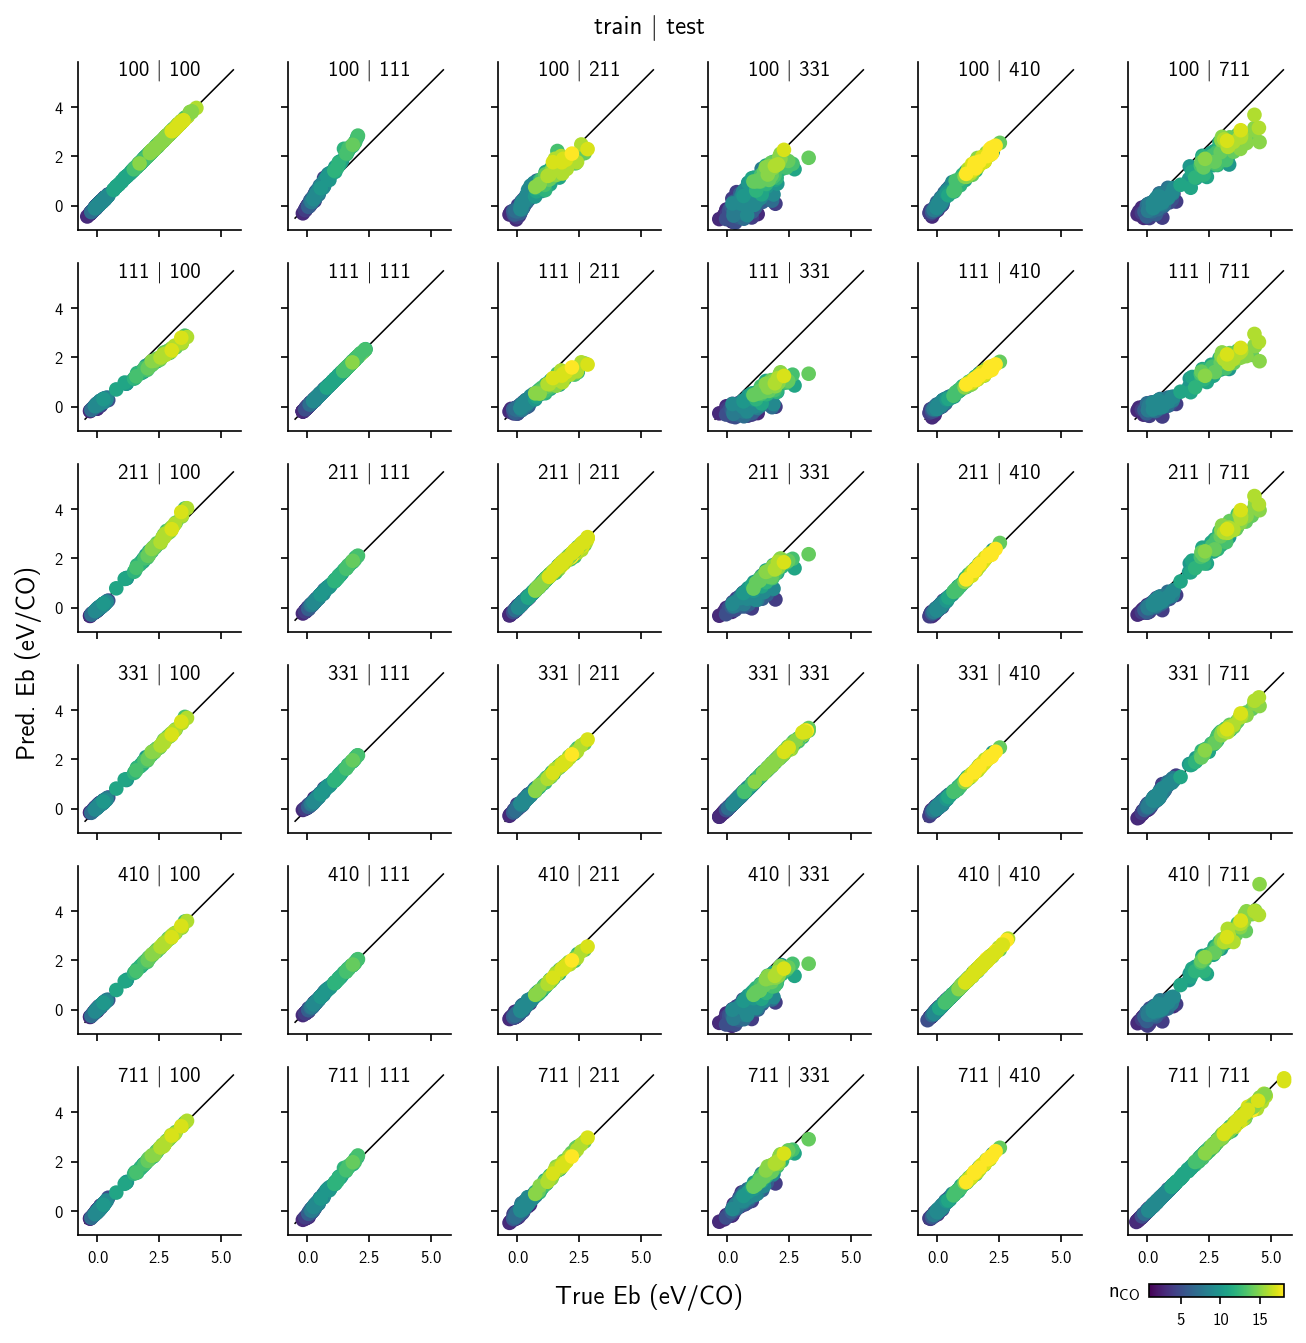

In [10]:
fig, axs = plt.subplots(6, 6, figsize=(9, 9), sharex=True, sharey=True)

norm = plt.Normalize(1, 18)

for ((train, test), grp), ax in zip(df.groupby(["train_facet", "test_facet"]), axs.ravel()):
    sc = ax.scatter(
        grp["ntrue"],
        grp["npred"],
        c=grp["nads"],
        norm=norm,
    )

    ax.plot(
        [-.5, 5.5],
        [-.5, 5.5],
        "k-",
        linewidth=0.75,
        zorder=-1
    )
    ax.set_aspect("equal")

    ax.annotate(f"{train} | {test}", (0.5, 0.95), xycoords="axes fraction", ha="center", va="center")

fig.suptitle("train | test")
fig.supxlabel("True Eb (eV/CO)", y=0.02)
fig.supylabel("Pred. Eb (eV/CO)", x=0.03)

cax = fig.add_axes([0.87, 0.03, 0.1, 0.01])
cbar = fig.colorbar(sc, cax=cax, orientation="horizontal")
fig.text(0.84, 0.03, "n$_{CO}$")

fig.tight_layout()
savefig(fig, "02-extrapolation-facets.png", dpi=300)
plt.show()

## covsplit results

In [11]:
exp = "covsplit"
expdf = df.loc[df["exp"] == exp]
table = metrics.loc[metrics["exp"] == exp].set_index("train_facet").drop(["exp", "test_facet"], axis=1)

/var/folders/2q/s8z166bx6s99wf5prpd1d3q0001w6_/T/ipykernel_19066/2307752836.py:37: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


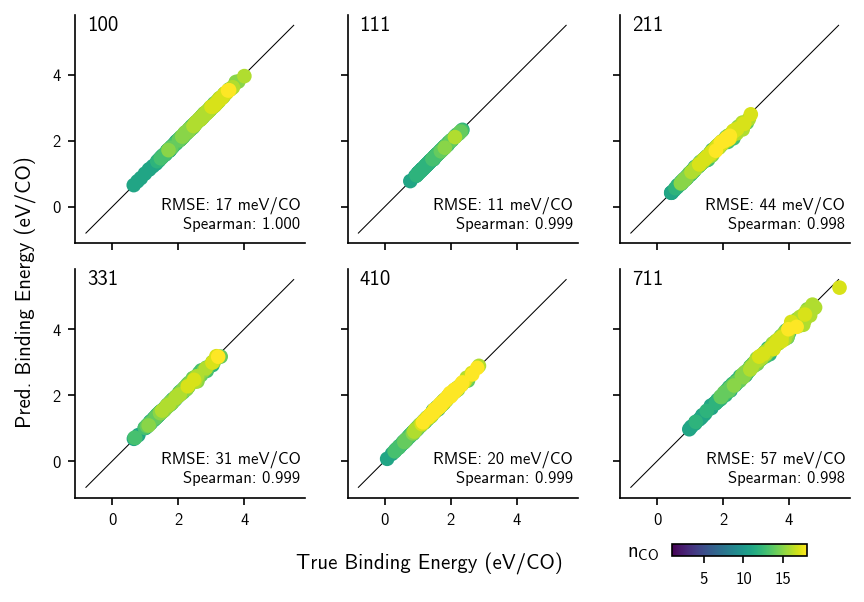

In [12]:
fig, axs = plt.subplots(2, 3, figsize=(6, 4), sharex=True, sharey=True)

norm = plt.Normalize(1, 18)
lims = (-0.8, 5.5)

for ax, (facet, grp) in zip(axs.reshape(-1), expdf.groupby("train_facet")):
    _x = grp["ntrue"]
    _y = grp["npred"]

    sc = ax.scatter(_x, _y, c=grp["nads"], norm=norm, cmap="viridis")

    ax.plot(lims, lims, "k-", zorder=-1, linewidth=0.5)

    ax.set_aspect("equal")

    annot = "\n".join([
        f"RMSE: {table.loc[facet].rmse * 1000:.0f} meV/CO",
        f"Spearman: {table.loc[facet].spearman:.3f}",
    ])
    ax.annotate(
        annot,
        (0.98, 0.05),
        xycoords="axes fraction",
        ha="right",
        va="bottom",
        fontsize=8
    )
    ax.annotate(facet, (0.05, 0.93), xycoords='axes fraction')

fig.supxlabel("True Binding Energy (eV/CO)", y=0.03, fontsize=10)
fig.supylabel("Pred. Binding Energy (eV/CO)", x=0.04, fontsize=10)

cax = fig.add_axes([0.77, 0.06, 0.15, 0.02])
cbar = fig.colorbar(sc, cax=cax, orientation="horizontal")
fig.text(0.72, 0.06, "n$_{CO}$")

fig.tight_layout()

savefig(fig, "02-extrapolation-coverage.png", dpi=300)
savefig(fig, "02-extrapolation-coverage.pdf")
plt.show()

## evencov results

In [13]:
exp = "evencov"
expdf = df.loc[df["exp"] == exp]
table = metrics.loc[metrics["exp"] == exp].set_index("train_facet").drop(["exp", "test_facet"], axis=1)

/var/folders/2q/s8z166bx6s99wf5prpd1d3q0001w6_/T/ipykernel_19066/1059000748.py:37: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


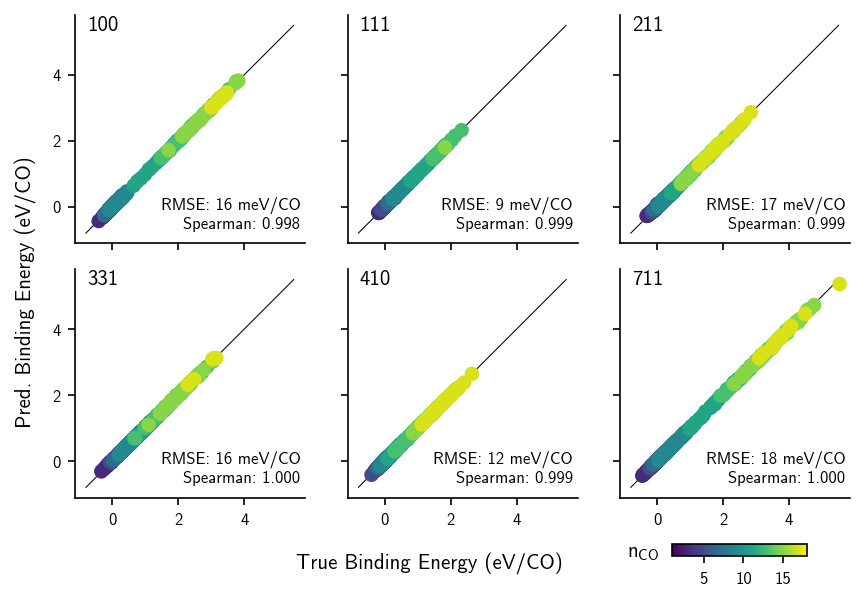

In [14]:
fig, axs = plt.subplots(2, 3, figsize=(6, 4), sharex=True, sharey=True)

norm = plt.Normalize(1, 18)
lims = (-0.8, 5.5)

for ax, (facet, grp) in zip(axs.reshape(-1), expdf.groupby("train_facet")):
    _x = grp["ntrue"]
    _y = grp["npred"]

    sc = ax.scatter(_x, _y, c=grp["nads"], norm=norm, cmap="viridis")

    ax.plot(lims, lims, "k-", zorder=-1, linewidth=0.5)

    ax.set_aspect("equal")

    annot = "\n".join([
        f"RMSE: {table.loc[facet].rmse * 1000:.0f} meV/CO",
        f"Spearman: {table.loc[facet].spearman:.3f}",
    ])
    ax.annotate(
        annot,
        (0.98, 0.05),
        xycoords="axes fraction",
        ha="right",
        va="bottom",
        fontsize=8
    )
    ax.annotate(facet, (0.05, 0.93), xycoords='axes fraction')

fig.supxlabel("True Binding Energy (eV/CO)", y=0.03, fontsize=10)
fig.supylabel("Pred. Binding Energy (eV/CO)", x=0.04, fontsize=10)

cax = fig.add_axes([0.77, 0.06, 0.15, 0.02])
cbar = fig.colorbar(sc, cax=cax, orientation="horizontal")
fig.text(0.72, 0.06, "n$_{CO}$")

fig.tight_layout()

savefig(fig, "02-extrapolation-evencov.png", dpi=300)
plt.show()

## Consolidating extrapolations in one plot

In [15]:
subdf = metrics.loc[metrics["train_facet"].apply(int) == metrics["test_facet"].apply(int)]
subdf["rmse"] = subdf["rmse"] * 1000
subdf = subdf.sort_values("train_facet", ascending=False)

table = subdf.pivot(index="train_facet", columns="exp", values="rmse").sort_index(ascending=False)
table = table

/var/folders/2q/s8z166bx6s99wf5prpd1d3q0001w6_/T/ipykernel_19066/3585307398.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subdf["rmse"] = subdf["rmse"] * 1000


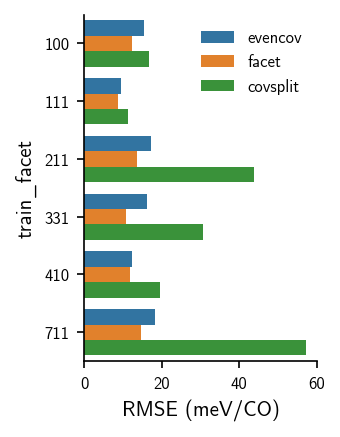

In [16]:
fig, ax = plt.subplots(figsize=(2, 3))

sns.barplot(
    data=subdf,
    hue="exp",
    y="train_facet",
    x="rmse",
    orient="h",
    ax=ax
)

ax.set_xlim(0, 60)
# ax.set_yticks(y)
# ax.set_yticklabels(table.index)
# ax.spines["left"].set_visible(False)

ax.legend(frameon=False)

ax.set_xlabel("RMSE (meV/CO)")

savefig(fig, "02-extrapolation-errors.pdf")
plt.show()

## Obtaining the errors for the model trained on all facets

In [17]:
dset_path = os.path.join(root_dir, "full", "full-test.xyz")

dset = read(dset_path, index=":")

full = []
for i, at in enumerate(dset):
    full.append({
        "index": i,
        "crystal_id": at.info["crystal_id"],
        "nads": at.arrays["adsorbate"].max(),
        "n_atoms": len(at),
        "true": at.info["energy"],
        "pred": at.info["MACE_energy"],
        "facet": at.info["facet"]
    })

full = pd.DataFrame(full)

full["npred"] = full["pred"] / full["nads"]
full["ntrue"] = full["true"] / full["nads"]

In [18]:
full_metrics = []

for facet, grp in full.groupby("facet"):
    err = grp["npred"] - grp["ntrue"]
    _rmse = np.sqrt((err ** 2).mean())
    full_metrics.append({"facet": facet, "rmse": _rmse})

full_metrics = pd.DataFrame(full_metrics)

In [19]:
full_metrics

,facet,rmse
0,100,0.010792
1,111,0.007759
2,211,0.013323
3,331,0.017148
4,410,0.010098
5,711,0.015122


### Breakdown: error per facet per coverage

In [20]:
full_metrics = []

for (nads, facet), grp in full.groupby(["nads", "facet"]):
    err = grp["npred"] - grp["ntrue"]
    _rmse = np.sqrt((err ** 2).mean())
    full_metrics.append({"facet": facet, "nads": nads, "rmse": _rmse, "n_points": len(grp)})

full_metrics = pd.DataFrame(full_metrics)
full_table = full_metrics.pivot(index="nads", columns="facet", values="rmse") * 1e3
full_num = full_metrics.pivot(index="nads", columns="facet", values="n_points")

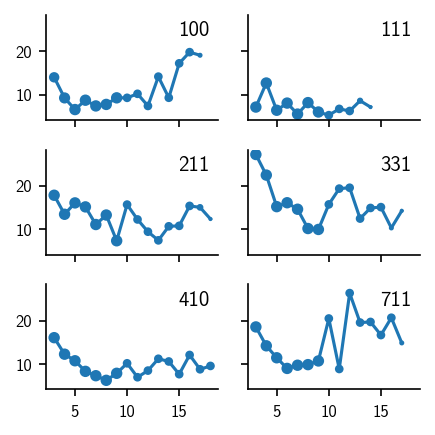

In [21]:
fig, axs = plt.subplots(3, 2, figsize=(3, 3), sharex=True, sharey=True)

for ax, (facet, row) in zip(axs.ravel(), full_table.T.iterrows()):
    ax.plot(row.index, row.values)
    ax.scatter(row.index, row.values, s=full_num[facet])
    ax.annotate(facet, (0.95, 0.95), xycoords="axes fraction", ha="right", va="top")

fig.tight_layout()
savefig(fig, "02-extrapolation-mace-breakdown.pdf")
plt.show()